# Homework 4- Table of Contents

### [Task 1. Propensity score matching](#1)
- [1.1. A naive analysis](#11)

- [1.2. A closer look at the data](#12)

- [1.3. A propensity score model](#13)

- [1.4. Balancing the dataset via matching](#14)

- [1.5. Balancing the groups further](#15)

- [1.6. A less naive analysis](#14)


### [Task 2. Applied ML](#2)
- [2.1. Load data](#21)

- [2.2. Train data with random forest](#22)

### Imports - libraries

In [1031]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from scipy import stats
import seaborn as sns
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

### Imports - data

In [1032]:
df = pd.read_csv('lalonde.csv', index_col = 0)

We check that data doesn't have any missing/null values:

In [1033]:
df.isnull().values.any()

False

## Task 1. Propensity Score Matching <a class="anchor" id="1"></a>

### Assignment Instructions
In this exercise, you will apply propensity score matching, which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "Evaluating the Econometric Evaluations of Training Programs" (1986). The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program. Your task is to determine the effectiveness of the "treatment" represented by the job training program.

### Dataset description

The dataset contain the following fatures:

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)


### Assumptions
The dataset contain several records with zero values for real earnings. Since we are trying to evaluate the efectiveness of the job program in the real earnings, we should also consider those who did not find a job. For this reason, we will keep these values in a first iterarion over the problem. 

### Plot Functions

We define the following functions to be used during the homework, when plotting and analysing the variables:

In [1137]:
def plot_hist(treated_df, control_df, features, title, range_):
    '''Funtion that receives a vector of continuos features to plot.
    Overlap the input features for both groups, treated and control'''
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey = True)
    
    plots = []
    #layers:
    for i in range(len(features)):
        plots.append(treated_df[features[i]])
        plots.append(control_df[features[i]])   
        
    #relative weight parameters for hist plot
    weights = []
    for i in range(len(plots)):
        weights.append(np.zeros_like(plots[i]) + 1. / plots[i].size) 
        
    #plot histograms
    for i in range(len(features)):
        j = i
        i = i*len(features)
        plots[i].plot.hist(ax = axes[0],weights=weights[i], title=('Treated Group: '+ title),
                        range =range_, alpha=0.5, label=features[j], bins = 20)
        plots[i+1].plot.hist(ax = axes[1], weights=weights[i+1], title=('Control Group: '+ title),
                        range =range_, alpha=0.5, label=features[j], bins = 20)
        
    axes[0].legend(loc="upper right")
    axes[1].legend(loc="upper right")    

    
def plot_bars(treated_df, control_df,feature, title, print_values = False):
    '''Funtion that receives a categorical feature to plot.
    Draws a barplot  for both groups, treated and control'''
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey = True);
    
    treated_values = (treated_df[feature].value_counts()/treated_df[feature].size).sort_index()
    control_values = (control_df[feature].value_counts()/control_df[feature].size).sort_index()
   
    #print auxiliar values
    if (print_values == True):
        print('The distribution in the treated group takes the following values: \n{}'.format(treated_values))
        print('The distribution in the control group takes the following values: \n{}'.format(control_values))
    
    #plot histograms
    treated_values.plot.bar(ax = axes[0],title=('Treated Group - '+ title),alpha=0.5)
    control_values.plot.bar(ax = axes[1],title=('Control Group - '+ title))
    
    #set legends
    axes[0].legend(loc="upper right")
    axes[1].legend(loc="upper right")  
    

def plot_box(feature, title):
    '''Funtion that receives a categorical feature to plot.
    Draws a box plot  for both groups, treated and control'''
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey = True);
    
    treated_values = treated[feature]
    control_values = control[feature]
    
    treated_values.plot.box(ax = axes[0],title=('Treated Group: '+ title), label=feature)
    control_values.plot.box(ax = axes[1],title=('Control Group: '+ title), label=feature)  

**Distribution Drawers**

In [1190]:
def plot_distribution(features, title1, title2, df1=treated, df2=control, bins=50):
    #fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey = True);
    
    treated_values = [df1[feature] for feature in features]
    non_treated_values = [df1[feature] for feature in features]
    
    colors = ['g','b', 'c','k', 'm', 'y', 'r']
    max_range = [max([max(treated_values[i]), max(non_treated_values[i])]) for i in range(len(features))]
    
    plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    for i in range(len(features)):
        plot_data(treated_values[i], bins, max_range[i], colors=[colors[i], colors[-(i+1)]], alpha=1/(2*i+1))
        plt.title(title1)
    
    plt.subplot(1,2,2)
    for i in range(len(features)):
        plot_data(non_treated_values[i], bins, max_range[i], colors=[colors[i], colors[-(i+1)]], alpha=1/(2*i+1))
        plt.title(title2)
    
def plot_data(data, bins, max_range, colors=['g', 'r'], alpha=1):
    # the histogram of the data
    n, bins, patches = plt.hist(data, bins, normed=True, facecolor=colors[0], range=(0,max_range), alpha=alpha)    
    # best fit of data
    (mu, sigma) = norm.fit(data)
    # add a 'best fit' line
    y = mlab.normpdf(bins, mu, sigma)
    plt.plot(bins, y, colors[1]+'--', linewidth=3)

### 1.1. A Naive Analysis<a class="anchor" id="11"></a>

At this point, we will start by comparing the distribution of the outcome variable (re78) between the two groups in an naively way, this is, without questioning the bias of such data. 

We start by spliting the treatment group and control group in two different categories:

In [1138]:
#create two distinct data frames for each group
treated = df[(df.treat ==1)]
control = df[(df.treat == 0)]

Let's check the general numerical values of real earning in the year of 1978 for both groups:

In [1139]:
#Real earnings description for people who took the job trainig program
treated.re78.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [1140]:
#Real earnings description for people who did not take the job trainig program
control.re78.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

**Observation:**

Considering what we know so far, there are several points that stand out in the descriptions above. 
One can see that the **mean** is higher for the control group, with a relative difference of approximately 9%. 

However, the **maximium** value, on the other side, is higer in the treated group with a relative difference of approximately 57%, which is a huge difference.

Note that the **quartiles** play an important role in this analysis since their robustness to outliers. We check that only for the first quartile, the trated group has a higher value, since for the following ones the control group presents higher earnings. 

From the analysis above, one can (naively) conclude that the treatment is more helpul for those who had small salaries.

Let's represent the values above with some plots. Note that for the following representations we consider **relative values**, since those are more meaningful comparing two groups of different size.

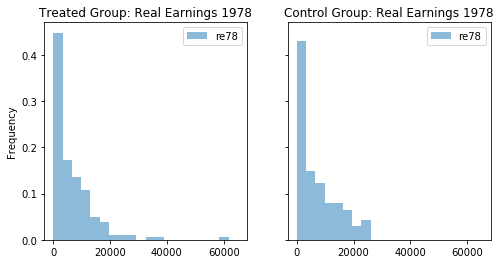

In [1141]:
plot_hist(treated, control, ['re78'], 'Real Earnings 1978', (0,65000))

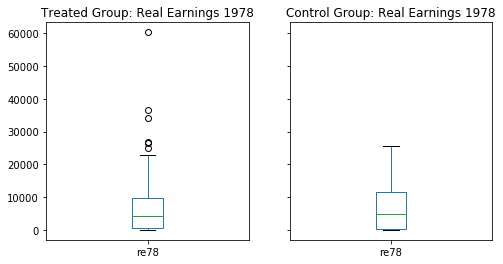

In [1142]:
plot_box('re78', 'Real Earnings 1978')

A naive "researcher" can conclude from this superficial analysis that ------------want to make propper hist with same bins width for both histograms----

### 1.2. A closer look at the data<a class="anchor" id="12"></a>

Let's take a closer look at the data before jumping to conclusions:

One can not just take into account the real earning in the year of 1978 to justify the  effectiveness of the "treatment" represented by the job training program. This could be biased. A good analysis should consider the "story" of a person, since it's obvious that people with higher education, or those who already had higher real earning values in the past few years are more likely to earn more, independently if they took the program or not.

For each feature in the dataset, we compare its distribution in the treated group with its distribution in the control group, using plots and numbers. 

**Is the `age` equal distributed in both groups?**

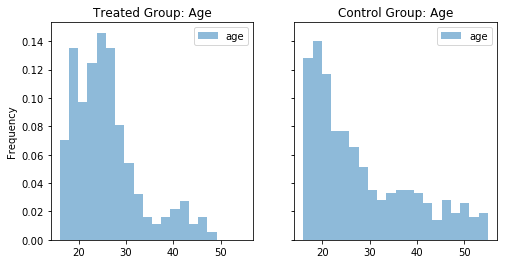

In [1143]:
age_range = (min(control['age'].min(),treated['age'].min()),max(control['age'].max(), treated['age'].max()))
plot_hist(treated, control,['age'], 'Age', age_range)

Eventhough the difference is not impressive, we can verify that the non treated group has a higher percentage of **older people**, in comparison with group one. This is relevant since higher earnings are usually associated with more years of professional career.

**Do both groups have a simillar `education`?**

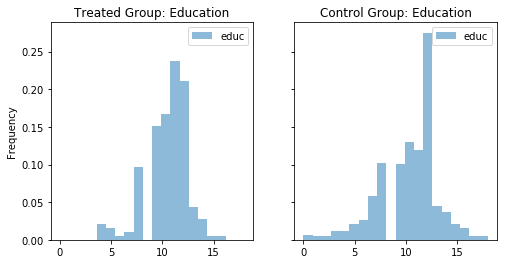

In [1144]:
educ_range = (min(control['educ'].min(),treated['educ'].min()),max(control['educ'].max(), treated['educ'].max()))
plot_hist(treated, control,['educ'], 'Education', educ_range)

Let's compare the mean of education years in both groups:

In [1145]:
mean_relativeDifference = ((treated.educ.mean()-control.educ.mean())/treated.educ.mean())*100
print("There's a {}% difference when comparing the mean of years of education for both groups".
      format(mean_relativeDifference))

There's a 1.068193387942603% difference when comparing the mean of years of education for both groups


A different years of education distributtion could affect the bias of the results, since more years of study are likely to be correlated with higher real earnings as well. However, the difference is just 1%, which is almost neglible.

**Are the three different `races` equally distributed in both groups?**

The distribution in the treated group takes the following values: 
0    0.156757
1    0.843243
Name: black, dtype: float64
The distribution in the control group takes the following values: 
0    0.797203
1    0.202797
Name: black, dtype: float64


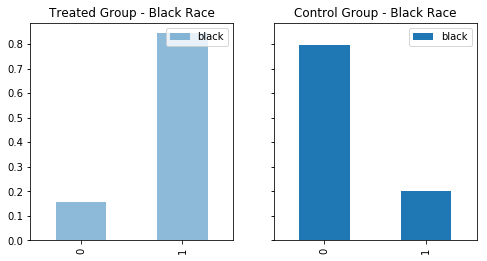

In [1146]:
plot_bars(treated, control, 'black', 'Black Race', print_values = True)

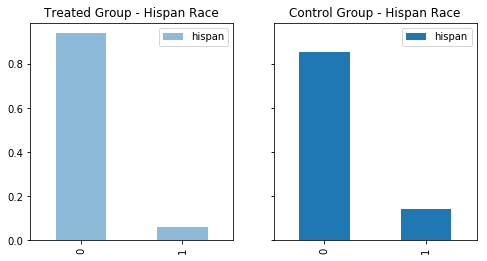

In [1147]:
plot_bars(treated, control, 'hispan', 'Hispan Race')

We can verify that the hispanic race is a minority in both groups. However, the same does not apply to the black race. In fact, more that 80% of people in the trated group belong to black race, in comparison with 20% in the non-treated group. 

**How is the `Marital status` distribuded in this two groups**

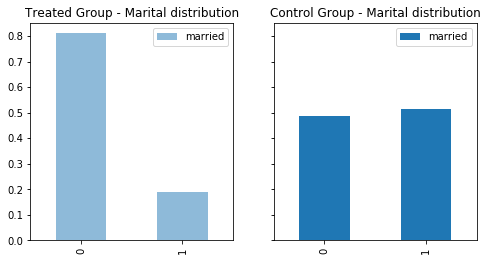

In [1148]:
plot_bars(treated, control, 'married','Marital distribution')

The Marital distribution is not exactly the same. However, one should also take into account that this parameter is not so likely to influence the real earnings. Since `married` is a dichotomous variable, let's check the `Point-biserial correlation coefficient` between these two features:

For more information about Point-biserial correlation coefficient click <a href="https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient">here</a>.

In [1046]:
stats.pointbiserialr(df['married'], df['re78'])

PointbiserialrResult(correlation=0.16235762667544129, pvalue=5.3062440838823211e-05)

We can verify they these features don't have a strong dependence.

**Is the distribution of people who got `no degrees` similar in both groups?**

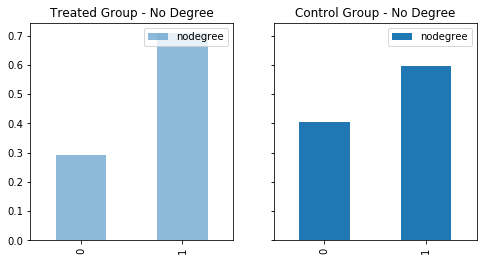

In [1150]:
plot_bars(treated, control,'nodegree','No Degree')

We verify that the number of people with no degrees is simillar in both cases.

**But how high were the `real earnings` before the treatment? And how do they compare to the ones from 1978?** 

In [1048]:
print('Average treated group real earnings in: \n1974: {}\n1975: {}'.format(treated.re74.mean(), treated.re75.mean()))
print('\nAverage control group real earnings in: \n1974: {}\n1975: {}'.format(control.re74.mean(), control.re75.mean()))

Average treated group real earnings in: 
1974: 2095.573688648649
1975: 1532.055313783784

Average control group real earnings in: 
1974: 5619.236506386947
1975: 2466.4844431235447


We see that the data is biased since the control group already had higher earnings before the beginning of the treatment! A more interest comparison would be to compare the difference between the earnings before and after the treatment. 

Keeping this in mind we create the following features:
- `re_PreTreament`: average of the earnings of 1974 and 1975:
- `improvement`: difference between the earnings in 1978 and the average of the earnings of 1974 and 1975


In [1049]:
#define re_PreTreatment
treated['re_PreTreatment']=(treated['re75']+treated['re74'])/2
control['re_PreTreatment']=(control['re75']+control['re74'])/2

#define improvement
treated['improvement']=treated['re78']-treated['re_PreTreatment']
control['improvement']=control['re78']-control['re_PreTreatment']

Which group has a higher `improvement`:

In [1050]:
print('Average improvement in the TREATED group: ', treated.improvement.mean())
print('Average improvement in the CONTROL group: ', control.improvement.mean())

Average improvement in the TREATED group:  4535.329029054054
Average improvement in the CONTROL group:  2941.3092675524467


From the values above the conclusion we take is completely different!

To ilustrate more intuitively, we will overlap the histogram distribution of the real earnings before and after treatment:

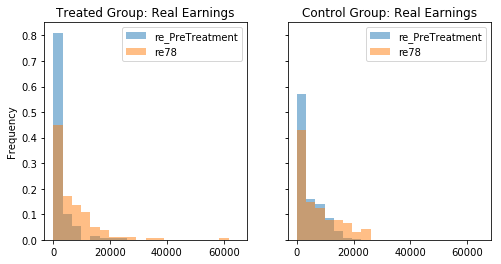

In [1051]:
plot_hist(treated, control,['re_PreTreatment', 're78'], 'Real Earnings', (0,65000))

**Conclusion**

If at some point, naively, we thought that the program was not effective, these values show the oposite!

By the observation of the histogram above, it's noticeable that the difference between the real earnings before and after treatment in the Treated Group is more striking then in the Control Group.

This lead us to conclude that the programe is in fact effective.

### 1.3. A propensity score model<a class="anchor" id="13"></a>

**Propensity Score Matching**:
To apply the propensity score matching, we will follow the following steps:

1. Run logistic regression **Question (1.3)**

2. Check that propensity score is balanced across treatment and comparison groups, and check that covariates are balanced across treatment and comparison groups within strata of the propensity score. **Question (1.3)**

3. Match each participant to one or more nonparticipants on propensity score **Question (1.4)**

4. Verify that covariates are balanced across treatment and comparison groups in the matched or weighted sample **Question (1.5)**

5. Multivariate analysis based on new sample **Question (1.6)**

**Run Logistic Regression**

In [1052]:
features = df[["age","educ","black","hispan","married","nodegree","re74","re75","re78"]]
labels = df["treat"]

logistic = LogisticRegression()
logistic.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

**Check that propensity score is balanced across treatment and comparison groups**

We create a new column in the dataframe,`probability_treat`, which represents the probability of receiving the treatment:

In [1118]:
df['probability_treat'] = logistic.predict_proba(features) [:,1]
df = df.reset_index()

Let's observe if `probability_treat` is balanced across treatment and comparison groups, plotting an histogram:

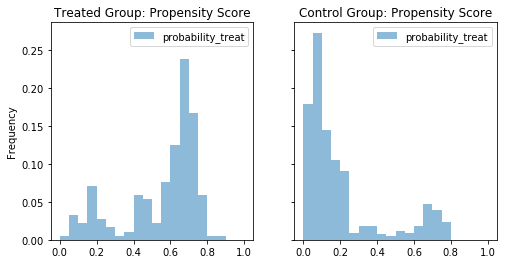

In [1120]:
plot_hist(df[(df.treat ==1)],df[(df.treat ==0)],['probability_treat'], 'Propensity Score', (0,1))

In [1121]:
print('treated group mean: ', df[(df.treat ==1)].probability_treat.mean())
print('control group mean: ', df[(df.treat ==0)].probability_treat.mean())

treated group mean:  0.5554526101002215
control group mean:  0.20415456056068765


As one would expect, we see that the propensity score is not balanced across the two groups, which introduce some bias on the results we've seen so far. To compensate such difference, we apply a **propensity score match**.

### 1.4. Balancing the dataset via matching <a class="anchor" id="14"></a>

In this section we follow on with the refered methods refered above to apply the propensity score matching.

**Match each participant to one or more nonparticipants on propensity score**

In [1163]:
import networkx as nx
from networkx.algorithms import bipartite

def create_graph(df):
    #create graph where each id identify a node
    graph = nx.Graph()
    graph.add_nodes_from(df[df['treat'] ==0 ].id, bipartite = 0)
    graph.add_nodes_from(df[df['treat'] ==1 ].id, bipartite = 1)
    return graph

def match_nodes(df, graph):
    '''We follow on with the creation of edges where each weight corresponds to the diference of propensity score.
    To find the "cheapest" matches we use the function "nx.max_weight_matching"
    Note however, that we have to insert a '-' signal, to transform a minimization problem into a maximization'''
    for row_treat in df[df['treat'] ==1 ].iterrows():
        for row_control in df[df['treat'] ==0 ].iterrows():
            graph.add_edge(row_treat[1]['id'],row_control[1]['id'], 
                       weight= (-np.abs(row_treat[1]['probability_treat'] - row_control[1]['probability_treat'])))
    
    matches = nx.max_weight_matching(graph, maxcardinality=True)
    
    return matches

In [1164]:
#initialize graph
graph = create_graph(df)

#creat edges and find minimal weight solution
matches_dict = match_nodes(df, graph)

Drop repetitive information in the dict:

In [1165]:
matches_dict_aux = {}
for key in matches_dict:
    if key in list(df[df['treat'] == 1].id):
        matches_dict_aux[key] = matches_dict[key]
matches_dict = matches_dict_aux

So far, we already have a dictionary with the matches with minimize the cost, this is, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects.

Now we create a new df for the control group with the matched values, and analyse `how the features are distributed after having applied the match`:

In [1186]:
matched_control = df[df['id'].isin(matches_dict.values())]

**Features Distribution**

We start by comparing `re78`:

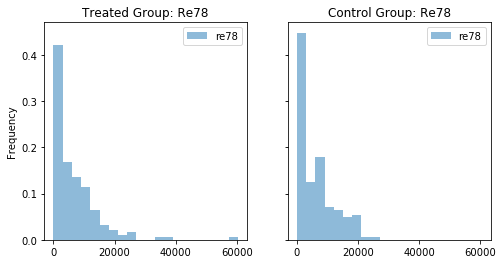

In [1187]:
#Real Earnings
re78_range = (min(matched_control['re78'].min(),treated['re78'].min()),
             max(matched_control['re78'].max(), treated['re78'].max()))
plot_hist(treated, matched_control,['re78'], 'Re78', re78_range)

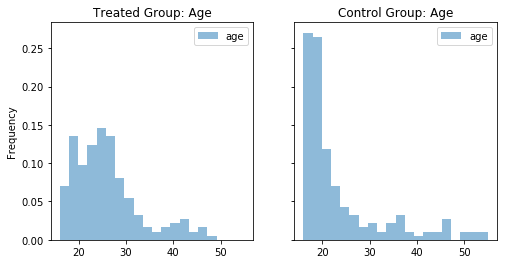

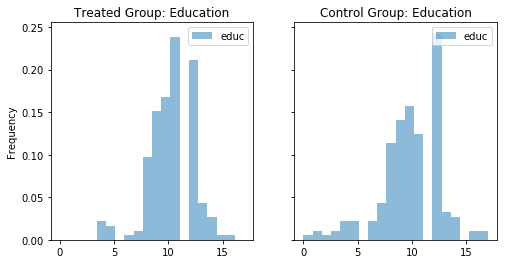

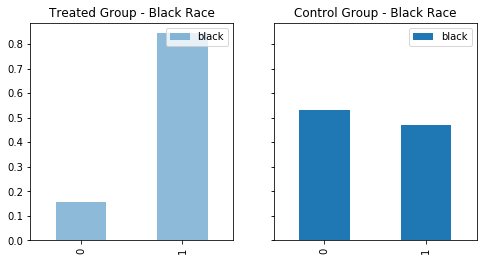

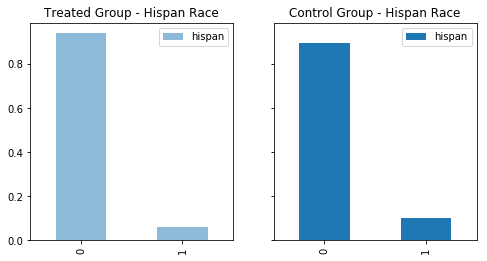

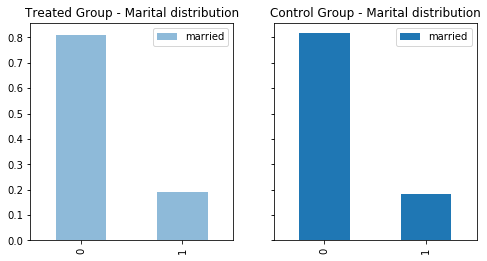

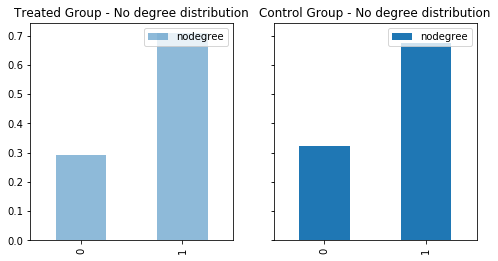

In [1188]:
#age
age_range = (min(matched_control['age'].min(),treated['age'].min()),
             max(matched_control['age'].max(), treated['age'].max()))
plot_hist(treated, matched_control,['age'], 'Age', age_range)

#years of education
educ_range = (min(matched_control['educ'].min(),treated['educ'].min()),
              max(matched_control['educ'].max(), treated['educ'].max()))
plot_hist(treated, matched_control,['educ'], 'Education', educ_range)

#Black Race
plot_bars(treated, matched_control,'black', 'Black Race')

#Hispan Race
plot_bars(treated, matched_control,'hispan', 'Hispan Race')

#married status
plot_bars(treated, matched_control, 'married','Marital distribution')

#no degree
plot_bars(treated, matched_control, 'nodegree','No degree distribution')

**Conclusion**

For the observation of the histograms above, we conclude that having matched the two groups using propensity score matching actually allowed to balance the distribution for all the features (including the married, which is now similar) except from the `black` and `age` features. In the next section we deal with such problem.

### 1.5. Balancing the groups further <a class="anchor" id="15"></a>

We want to analyse the disparity in each match. For this reson we ceate the following df:

(array([ 78.,   9.,   5.,   3.,   2.,   3.,   1.,   3.,   1.,   0.,   0.,
          0.,   1.,   1.,   0.,   1.,   0.,   0.,   2.,   0.,   1.,   5.,
          4.,   4.,   2.,   1.,   3.,   4.,   0.,   3.,   0.,   1.,   3.,
          1.,   3.,   1.,   3.,   2.,   1.,   3.,   2.,   1.,   1.,   7.,
          6.,   1.,   5.,   3.,   2.,   2.]),
 array([ 0.        ,  0.01153695,  0.0230739 ,  0.03461085,  0.04614779,
         0.05768474,  0.06922169,  0.08075864,  0.09229559,  0.10383254,
         0.11536949,  0.12690644,  0.13844338,  0.14998033,  0.16151728,
         0.17305423,  0.18459118,  0.19612813,  0.20766508,  0.21920202,
         0.23073897,  0.24227592,  0.25381287,  0.26534982,  0.27688677,
         0.28842372,  0.29996067,  0.31149761,  0.32303456,  0.33457151,
         0.34610846,  0.35764541,  0.36918236,  0.38071931,  0.39225625,
         0.4037932 ,  0.41533015,  0.4268671 ,  0.43840405,  0.449941  ,
         0.46147795,  0.4730149 ,  0.48455184,  0.49608879,  0.50762574,
 

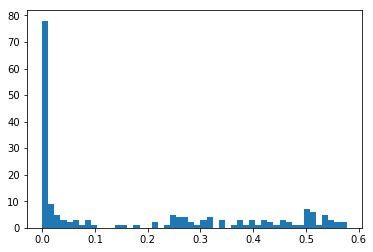

In [1189]:
#include probabilitytreat in matched df
treated = df[(df.treat ==1)]

#concatenate df's
treated['control_match'] = treated['id'].replace(matches_dict)
subjects = pd.merge(treated, matched_control, how='inner',left_on='control_match', right_on = 'id',
                          suffixes=('_tr', '_ctr'))

#calculate matching error
match_error = np.abs(subjects['probability_treat_tr'] - subjects['probability_treat_ctr'])
plt.hist(match_error, bins=50)

We see that eventhough the error is little for the majority of matches, there are still some outliers.

### 1.6. A less naive analysis <a class="anchor" id="16"></a>

TO THINK ABOUT: WHICH FACTORS CAN INFLUENCE ONE GROUP INSTEAD OF THE OTHER? IS THERE ANY BIAS HERE?
    CAN WE CONSIDER THAT PEOPLE WHO TOOK THE JOB TRAINING PROGRAM ARE FROM THE BEGINNING MORE LIKELY TO EARN MORE
    SINCE THEY SHOW TO BE MOTIVATED IN SO? - CHECK CAREFULLY WHICH TYPE OF PEOPLE PARTICIPATED IN THE PROGRAM

## Task 2. Swiss Unemployment Rates Analysis - *amstat* dataset <a class="anchor" id="2"></a>

### Assignment Instructions

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn (link).
TF-IDF, short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using TfidfVectorizer. Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the feature_importances_ attribute of your random forest and discuss the obtained results.

### 2.1. Pick a DataSet to analyse <a class="anchor" id="21"></a>

### 2.2. Choropleth map of Cantonal Unemployment Rates  <a class="anchor" id="22"></a>